STEP 3: Modeling Baseline Sentiment

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load engineered features
features_path = "data_out/features_engineered.parquet"
df = pd.read_parquet(features_path)
print("Loaded engineered features:", df.shape)
print("Label distribution:\n", df["_y"].value_counts())

# Drop non-feature columns
drop_cols = ["_subject", "_trial", "_win", "_y"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].values
y = df["_y"].values

# Train/test split (stratified to maintain label ratios)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Loaded engineered features: (4924, 130)
Label distribution:
 _y
1    3422
2    1288
0     214
Name: count, dtype: int64
Train shape: (3939, 126) Test shape: (985, 126)


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Handle infinite and NaN values in train and test sets before scaling
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Features standardized. Sample mean/std:")
print(np.mean(X_train_scaled, axis=0)[:5], np.std(X_train_scaled, axis=0)[:5])

Features standardized. Sample mean/std:
[ 1.21005572e-15  2.11007201e-15  1.08181214e-15  3.31522347e-15
 -5.56718080e-16] [1. 1. 1. 1. 1.]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Logistic Regression with class balancing
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test_scaled)

# Metrics
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Macro F1:", f1_score(y_test, y_pred_logreg, average="macro"))
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.5461928934010152
Macro F1: 0.4642095985370718
              precision    recall  f1-score   support

           0       0.18      0.70      0.29        43
           1       0.80      0.53      0.64       684
           2       0.40      0.57      0.47       258

    accuracy                           0.55       985
   macro avg       0.46      0.60      0.46       985
weighted avg       0.67      0.55      0.58       985



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200, max_depth=None, class_weight="balanced", random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Macro F1:", f1_score(y_test, y_pred_rf, average="macro"))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9634517766497462
Macro F1: 0.9181119730755863
              precision    recall  f1-score   support

           0       0.97      0.72      0.83        43
           1       0.95      1.00      0.97       684
           2       1.00      0.91      0.95       258

    accuracy                           0.96       985
   macro avg       0.97      0.88      0.92       985
weighted avg       0.96      0.96      0.96       985



In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Macro F1:", f1_score(y_test, y_pred_xgb, average="macro"))
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:11:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9614213197969543
Macro F1: 0.916284196857125
              precision    recall  f1-score   support

           0       0.97      0.72      0.83        43
           1       0.95      1.00      0.97       684
           2       1.00      0.91      0.95       258

    accuracy                           0.96       985
   macro avg       0.97      0.87      0.92       985
weighted avg       0.96      0.96      0.96       985



In [ ]:
import joblib
import os

os.makedirs("models", exist_ok=True)

# Save XGBoost + scaler together
joblib.dump({"model": xgb_clf, "scaler": scaler}, "models/xgb_sentiment.pkl")
print("Saved XGBoost baseline model to models/xgb_sentiment.pkl")

Saved XGBoost baseline model to models/xgb_sentiment.pkl


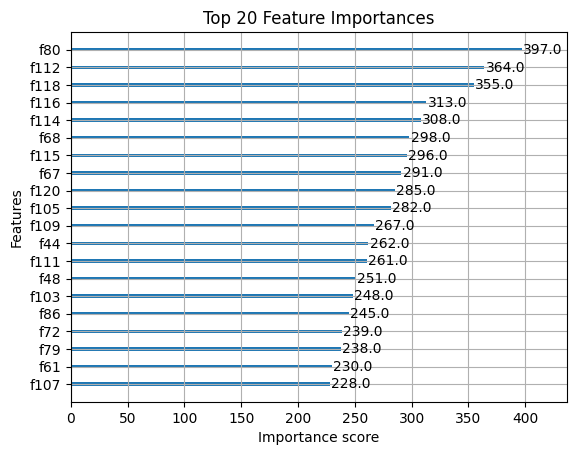

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_clf, max_num_features=20, importance_type='weight')
plt.title("Top 20 Feature Importances")
plt.show()